# Fermionic Tweezer Hardware

## Experimental system

In this tutorial, we give a concrete example of how the fermionic setting introduced in the [first tutorial](./01_introduction_and_fermionic_circuits.ipynb) can be used to describe a realistic cold atomic experimental setup as a backend in Qiskit-cold-atom. We call this setting the "fermionic tweezer hardware".

In this architecture, individual fermionic atoms are trapped and cooled in optical microtraps or "tweezers" [1]. The trapped fermionic atoms come in two different atomic states related to the nuclear spin which we thus refer to as spin-up ($\uparrow$) and spin-down ($\downarrow$). The system is cooled down to a point where only the lowest spatial mode of each tweezer can be occupied by at most one $\uparrow$- and one $\downarrow$-atom. The occupations of the individual tweezers are the carriers of quantum information in this system.

The tweezers are laid out in a linear geometry. Schematically, we can picture the fermionic register with a given number of $\uparrow$-particles (red) and $\downarrow$-particles (blue) distributed over an array of wells:

<img src="aux_files/fermionic_tweezer_array.png" width="500">

Each tweezer can be initialized with a desired number of $\uparrow$- and $\downarrow-$ particles as a state preparation step. 

## Circuit description

### Initialization

In the circuit description, the initialization of the tweezers with atoms is carried out by the `LoadFermions` instruction. In the fermionic setting each individual fermionic mode is assigned one wire in the circuit. In our case, each spatial mode supports two spin modes. The circuit will thus consist of $2L$ wires, where the first $L$ wires are by convention taken to represent the spin-$\uparrow$ modes, assigning the remaining wires to the spin- $\downarrow$ modes.  

The [ColdAtomProvider](./05_cold_atom_provider.ipynb) includes the backend to simulate the fermionic tweezer hardware. This  backend (like all fermionic backends) comes with an `initialize_circuit` method that creates an empty circuit initialized with the given atomic occupations. The backend is defined for a system consisting of $L=4$ tweezers. For example, the schematic state drawn above can be initialized like this:  

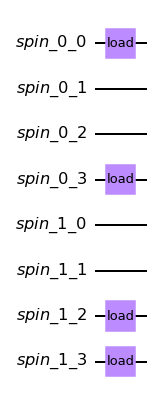

In [1]:
from qiskit_cold_atom.providers import ColdAtomProvider

provider = ColdAtomProvider()
backend = provider.get_backend("fermionic_tweezer_simulator")

# give initial occupations separated by spin species
qc = backend.initialize_circuit([[1, 0, 0, 1], [0, 0, 1, 1]])

qc.draw(output='mpl')

### Readout:

A measurement on this system will yield the occupations per spin species of the individual tweezer modes [2]. Therefore, similar to qubit circuits, each wire gets projected to 0 (mode not occupied) or 1 (mode occupied) upon measurement of the circuit.

In [2]:
qc.measure_all()

print("measured counts: ", backend.run(qc, shots=10).result().get_counts())
print("measured counts: ", backend.run(qc, shots=10).result().get_memory())

measured counts:  {'10010011': 10}
measured counts:  ['10010011', '10010011', '10010011', '10010011', '10010011', '10010011', '10010011', '10010011', '10010011', '10010011']


### Gates and dynamics

As laid out in the introductory notebook, within Qiskit-cold-atom, the unitary gates available in the hardware are described on the basis of their generating Hamiltonian.
Here, the physical dynamics of the 1-D tweezer array are governed by a Fermi-Hubbard Hamiltonian in second quantization: 

$$ 
 H_{\text{FH}}(\boldsymbol{J},U,\boldsymbol{\mu}) =  \underbrace{\sum_{i=1,\sigma}^{L-1} -J_i (f^\dagger_{i,\sigma} f_{i+1,\sigma} + f^\dagger_{i+1,\sigma} f_{i,\sigma} )}_{\text{Tunneling/Hopping}} + \underbrace{U \sum_{i=1}^{L}  n_{i,\uparrow}n_{i,\downarrow}}_{\text{interaction}} + \underbrace{\sum_{i=1,\sigma}^{L} \mu_i n_{i,\sigma}}_{\text{potential offset}} 
$$

Here, $f_{i,\sigma}, f^\dagger_{i,\sigma}$ are annihilation/creation operators for atoms in tweezers at site $i$ with spin $\sigma$ and $n_{i,\sigma} = f^\dagger_{i,\sigma} f_{i,\sigma}$ is the number operator.  

The dynamics depend on the parameters $\{ \boldsymbol{J}, U, \boldsymbol{\mu} \}$ that determine the strength of the different contributions:

- The first term describes hopping between the site $i$ and its neighboring site $i+1$ (for both spin species) through the tunnel effect. The parameter $J_i$ determines the strength of this hopping and can be tuned by adjusting the potential barrier between these two wells.
    
- The second term describes an interaction between two atoms when they occupy the same site. It is controlled globally by the parameter $U$ set by an external magnetic field exploiting a Feshbach resonance.

- The third term describes local offsets in the potential which can locally imprint a phase by tuning $\mu_i$.
   
Here, we assume that the parameters $\{ J_i, U, \mu_i \}$ are tuned individually and can be switched on and off quasi-instantaneously.
We can thus use this Hamiltonian to define a set of unitary quantum gates that can be implemented on the hardware. 
By choosing specific values $\{ J_i, U, \mu_i \}$, the unitary of the gate is defined as $U_{\text{FH}} = e^{-i H_{\text{FH}}(J_i, U, \mu_i)}$. 

Let's look at a first example circuit where a global \"Fermi-Hubbard-gate\" is applied:

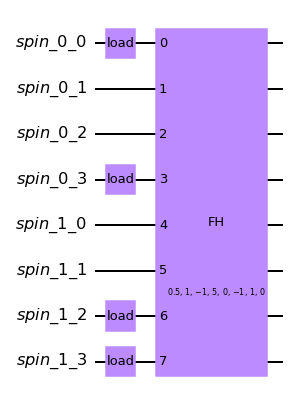

In [3]:
from qiskit_cold_atom.fermions.fermion_gate_library import FermiHubbard

qc = backend.initialize_circuit([[1, 0, 0, 1], [0, 0, 1, 1]])

all_modes=range(8)

qc.append(FermiHubbard(num_modes=8, j=[0.5, 1., -1.], u=5., mu=[0., -1., 1., 0.]), qargs=all_modes)

# alternatively append the FH gate directly:
# qc.FH(j=[0.5, 1., -1.], u=5., mu=[0., -1., 1., 0.], modes=all_modes)

qc.draw(output='mpl')

This Fermi-Hubbard gate always acts globally on the entire fermionic register. The dynamics can be broken apart to separate the different interactions in the hardware by having only one term of the Hamiltonian active at a given time to create three individual gates:

- a "hopping" gate with unitary $U_{\text{hop}}(J_i) = U_{\text{FH}}( J, U=0, \mu=0)$. This hopping gate is a local gate that turns on the hopping of particles to neighbouring wells which is the crucial tool to create superposition in the occupation number basis. 

- an "interaction" gate with unitary $U_{\text{int}}(U) = U_{\text{FH}}( U, J=0, \mu=0)$. This interaction gate is always a global gate acting on the entire register. It turns on the interaction of particles which affects only the states where two particles of opposite spin occupy the same well. It is thus diagonal in the occupation number basis and imprints conditional phases on the states with double occupations.

- a "local phase" gate with unitary $U_{\text{ext}}(\mu) = U_{\text{FH}}( \mu, J=0, U=0)$. This gate acts locally on individual tweezers. For each index $i$ in the tweezer array, the parameter $\mu_i$ creates an external offset potential. This operation is also diagonal in the occupation number basis and imprints local phases.  

These gates are available as `FermionicGates` from the `fermion_gate_library`. Let's use them to build up a small circuit:

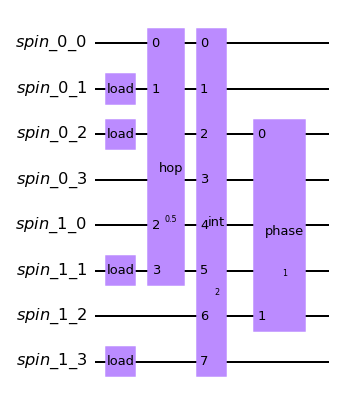

In [4]:
from qiskit_cold_atom.fermions.fermion_gate_library import Hopping, Interaction, LocalPhase

qc = backend.initialize_circuit([[0, 1, 1, 0], [0, 1, 0, 1]])

hopping_gate = Hopping(num_modes=4, j=[0.5])
interaction_gate = Interaction(num_modes=8, u=2.)
phase_gate = LocalPhase(num_modes=2, mu=[1.])

qc.append(hopping_gate, qargs=[0, 1, 4, 5])
qc.append(interaction_gate, qargs=all_modes)
qc.append(phase_gate, qargs=[2, 6])

# equivalently, we can build the same circuit with a shortcut notation:
# qc.hop_fermions([0.5], [0, 1, 4, 5])
# qc.int_fermions(2., all_modes)
# qc.phase_fermions([1.], [2, 6])

qc.draw(output= "mpl")

As detailed in the introduction notebook, these gates have their generating Hamiltonians defined as a `FermionicOp`:

In [5]:
print("hopping generator: \n", hopping_gate.generator)
print("\n interaction generator: \n",interaction_gate.generator)
print("\n phase generator: \n", phase_gate.generator)

hopping generator: 
   +-II * (-0.5+0j)
+ -+II * (0.5+0j)
+ II+- * (-0.5+0j)
+ II-+ * (0.5+0j)

 interaction generator: 
   IIINIIIN * (2+0j)
+ IINIIINI * (2+0j)
+ INIIINII * (2+0j)
+ NIIINIII * (2+0j)

 phase generator: 
   IN * (1+0j)
+ NI * (1+0j)


Let's run this circuit on the backend:

In [6]:
qc.measure_all()

job = backend.run(qc, shots=100)

print("counts: ", job.result().get_counts())

print("time taken: ", job.result().time_taken)

counts:  {'01100101': 58, '10101001': 10, '01101001': 12, '10100101': 20}
time taken:  0.11716270446777344


Note that in the measured result bitstrings, the number of 1s is always constant. This is of course a direct result of the fact that all dynamics conserve the total number of atoms initialized in the circuit. 

This is also reflected in the basis states over which the simulation is performed:

In [7]:
print(backend.get_basis(qc))


 0.  |0, 0, 0, 0, 1, 1, 1, 1>
 1.  |0, 0, 0, 1, 0, 1, 1, 1>
 2.  |0, 0, 0, 1, 1, 0, 1, 1>
 3.  |0, 0, 0, 1, 1, 1, 0, 1>
 4.  |0, 0, 0, 1, 1, 1, 1, 0>
 . 
 . 
 .
 65.  |1, 1, 1, 0, 0, 0, 0, 1>
 66.  |1, 1, 1, 0, 0, 0, 1, 0>
 67.  |1, 1, 1, 0, 0, 1, 0, 0>
 68.  |1, 1, 1, 0, 1, 0, 0, 0>
 69.  |1, 1, 1, 1, 0, 0, 0, 0>


However, this circuit not only conserves the total atom number, but also the atom number per spin species. This can be leveraged to reduce the dimension of the basis of the simulation dramatically. When running the circuit, by passing `num_species = 2` as a keyword argument, the solver checks for conservation of each species. In our example, this almost halves the dimension of the basis. This also works for any number of different fermionic species.

In [8]:
job_efficient = backend.run(qc, shots=100, num_species=2)

print("counts: ", job_efficient.result().get_counts())

print("time taken: ",job_efficient.result().time_taken)

print("basis: ", backend.get_basis(qc, num_species=2))

counts:  {'01100101': 63, '10101001': 4, '01101001': 21, '10100101': 12}
time taken:  0.08462715148925781
basis:  
 0.  |0, 0, 1, 1>|0, 0, 1, 1>
 1.  |0, 0, 1, 1>|0, 1, 0, 1>
 2.  |0, 0, 1, 1>|0, 1, 1, 0>
 3.  |0, 0, 1, 1>|1, 0, 0, 1>
 4.  |0, 0, 1, 1>|1, 0, 1, 0>
 . 
 . 
 .
 31.  |1, 1, 0, 0>|0, 1, 0, 1>
 32.  |1, 1, 0, 0>|0, 1, 1, 0>
 33.  |1, 1, 0, 0>|1, 0, 0, 1>
 34.  |1, 1, 0, 0>|1, 0, 1, 0>
 35.  |1, 1, 0, 0>|1, 1, 0, 0>


### Spin-changing gates:

In addition to the gates introduced above that stem from the internal Fermi-Hubbard dynamics, resonant laser pulses can be used to locally manipulate the spin state of the atoms in an individual tweezer. In this way, $x$ - $y$ and $z-$rotations of the two level system defined by the spin-$\uparrow$ and spin-$\downarrow$ state at a single site can be performed. 
These gates can break the spin-conservation symmetry we have observed in the circuits above:

In [9]:
from qiskit_cold_atom.fermions.fermion_gate_library import FermionRX, FermionRY, FermionRZ
import numpy as np

qc = backend.initialize_circuit([[0, 1, 1, 0], [0, 1, 0, 1]])


# flip the spin of the atom at site 3
qc.append(FermionRX(np.pi), [2, 6])

# equivalently use shortcut
# qc.rx_fermions(np.pi, [2, 6])

qc.measure_all()

print("counts: ", backend.run(qc, num_species=2).result().get_counts())

print("basis dimension :", backend.get_basis(qc).dimension)


counts:  {'01100101': 1000}
basis dimension : 70


Note that the wire indices of the gates always need to specify the indices of both spin modes corresponding to a single spatial mode. 

## Description as a backend

The framework describing the fermionic tweezer hardware is implemented as a dedicated _backend_.

We could have also run the circuits above on the generic `FermionSimulator` backend. However, by defining a specific `FermionicTweezerSimulator` backend, we have a direct way of describing the accepted gates, size and other settings of this specific system in the backend's _configuration_. 

In the backend configuration, we can explicitly state which instructions the backend accepts and in what way these instructions can be applied to the fermionic register. The latter is achieved through _coupling maps_ which define the accepted wiring for all gates. For reference, let's take a look at the entire configuration of the `FermionicTweezerSimulator` below:

In [10]:
from pprint import pprint

tweezer_configuration = backend.configuration().to_dict()

pprint(tweezer_configuration)

{'backend_name': 'fermionic_tweezer_simulator',
 'backend_version': '0.0.1',
 'basis_gates': ['hop', 'int', 'phase', 'FH', 'fer_rx', 'fer_ry', 'fer_rz'],
 'cold_atom_type': 'fermion',
 'conditional': False,
 'coupling_map': 'linear',
 'description': 'simulator of a fermionic tweezer hardware. The first half of '
                'wires in a circuit denote the occupations of the spin-up '
                'fermions and the last half of wires denote the spin-down '
                'fermions',
 'dynamic_reprate_enabled': False,
 'gates': [{'coupling_map': [[0, 1, 4, 5],
                             [1, 2, 5, 6],
                             [2, 3, 6, 7],
                             [0, 1, 2, 4, 5, 6],
                             [1, 2, 3, 5, 6, 7],
                             [0, 1, 2, 3, 4, 5, 6, 7]],
            'description': 'hopping of atoms to neighboring tweezers',
            'name': 'hop',
            'parameters': ['j_i'],
            'qasm_def': '{}'},
           {'coupling_ma

Note how each gate has a custom coupling map which defines the allowed wire indices with which the gate can be added to the circuit.

Apart from that, the `FermionicTweezerSimulator` inherits all functionality of the generic `FermionSimulator` such as retrieving the statevector and the unitary. 

## Outlook

The fermionic tweezer simulator backend can be used as a tool to study what kind of quantum computations can be performed in a realistic experimental hardware based on cold fermions. 
As an example application, we  study the time-evolution of the FH-dynamics native to the system [(see tutorial 6)](./06_time_evolution.ipynb).

The supported functionality for fermionic circuits in Qiskit-cold-atom can in principle be utilized to describe a larger class of fermionic setups, i.e. other trap- or lattice-based architectures that can deterministically prepare, manipulate and measure individual atoms. Such experiments might have different underlying Hamiltonian dynamics, number of spin species, available gates and coupling maps. 

This tutorial should be seen as just one example of how this framework can be used to build a backend for one specific experimental setting. 

Interested users are encouraged to explore this possibility of describing suitable fermionic gates and backend configurations of other setups.

## References
[1] Murmann, Simon et al. *Two Fermions in a double well: Exploring a fundamental building block of the Hubbard model* Physical Review Letters 114, 080402, 2015

[2] Bergschneider, Andrea et al. *Experimental Characterization of Two-Particle Entanglement through Position and Momentum Correlations*, Nature Physics, 15 604-4, 2019

In [11]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright